In [1]:
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
import struct
from mpl_toolkits.mplot3d import Axes3D
from scipy.fftpack import fft2, ifft2, fftshift, ifftshift
from filter_BU import filt_B

In [2]:
def read_momrate(fmom, ix, iz, nt=5000, nx=125, nz=125, comp=0):
    with open(fmom, 'rb') as fid:
        skip = (nt * 6 * 4 + 12) * (iz * nx + ix) + 12
        data = np.fromfile(fid, dtype='float32', count=6 * nt, offset=skip).reshape(-1, 6)
    return data if comp == None else data[:, comp] 

In [3]:
np.random.seed(0)
ix, iz = np.random.randint(125), np.random.randint(125)
ix, iz = 0, 0
dt1, dt2 = 0.001, 0.00075
nt1, nt2 = 5000, 6600
sliprate = np.fromfile('../la_habra_medium_8m_gpu_dm_abc50/sliprate.bin', dtype='float32').reshape(-1, 125, 125)
mom1 = read_momrate('../toy/momrate_LaHabra.20m.sm.10hz.bin', ix, iz, nt=nt1)
mom2 = read_momrate('../la_habra_medium_8m_gpu_dm_abc50/momrate.dat', ix, iz, nt=nt2)
srate = sliprate[:, iz, ix]

srate = srate / np.max(np.abs(srate)) * np.max(abs(mom2))
if abs(np.min(mom2)) > abs(np.max(mom2)):
    srate *= -1
    

In [4]:
subfault = np.genfromtxt('../la_habra_medium_8m_gpu_dm_abc50/subfaults.idx')
slip = np.sum(sliprate, axis=0).ravel() * dt1
sum_mom = list(subfault[i, 4] * subfault[i, 3] * slip[i] \
                 for i in range(len(subfault)))
print(f'Total moment = {sum(sum_mom):.3e} Nm')

Total moment = 5.788e+16 Nm


In [5]:
total = 0
moment1 = np.zeros((125, 125))
moment2 = np.zeros((125, 125))
for j in range(125):
    if j % 20 == 0: print(j)
    for i in range(125):
        tmp = read_momrate('../la_habra_medium_8m_gpu_dm_abc50/momrate.dat',
                           i, j, nt=nt2, comp=None)
        tmp = np.sum(tmp, axis=0).ravel() * dt2
        moment2[j, i] = np.sqrt(np.sum([tmp[k] ** 2 for k in [0,1,2,3,4,5,3,4,5]]) / 2)
        tmp = read_momrate('../toy/momrate_LaHabra.20m.sm.10hz.bin',
                          i, j, nt=nt1, comp=None)
        tmp = np.sum(tmp, axis=0).ravel() * dt1
        moment1[j, i] = np.sqrt(np.sum([tmp[k] ** 2 for k in [0,1,2,3,4,5,3,4,5]]) / 2)
print(np.sum(moment1), np.sum(moment2))

0
20
40
60
80
100
120
5.788001111196145e+16 5.788622850564705e+16


(0.25, 1.5)

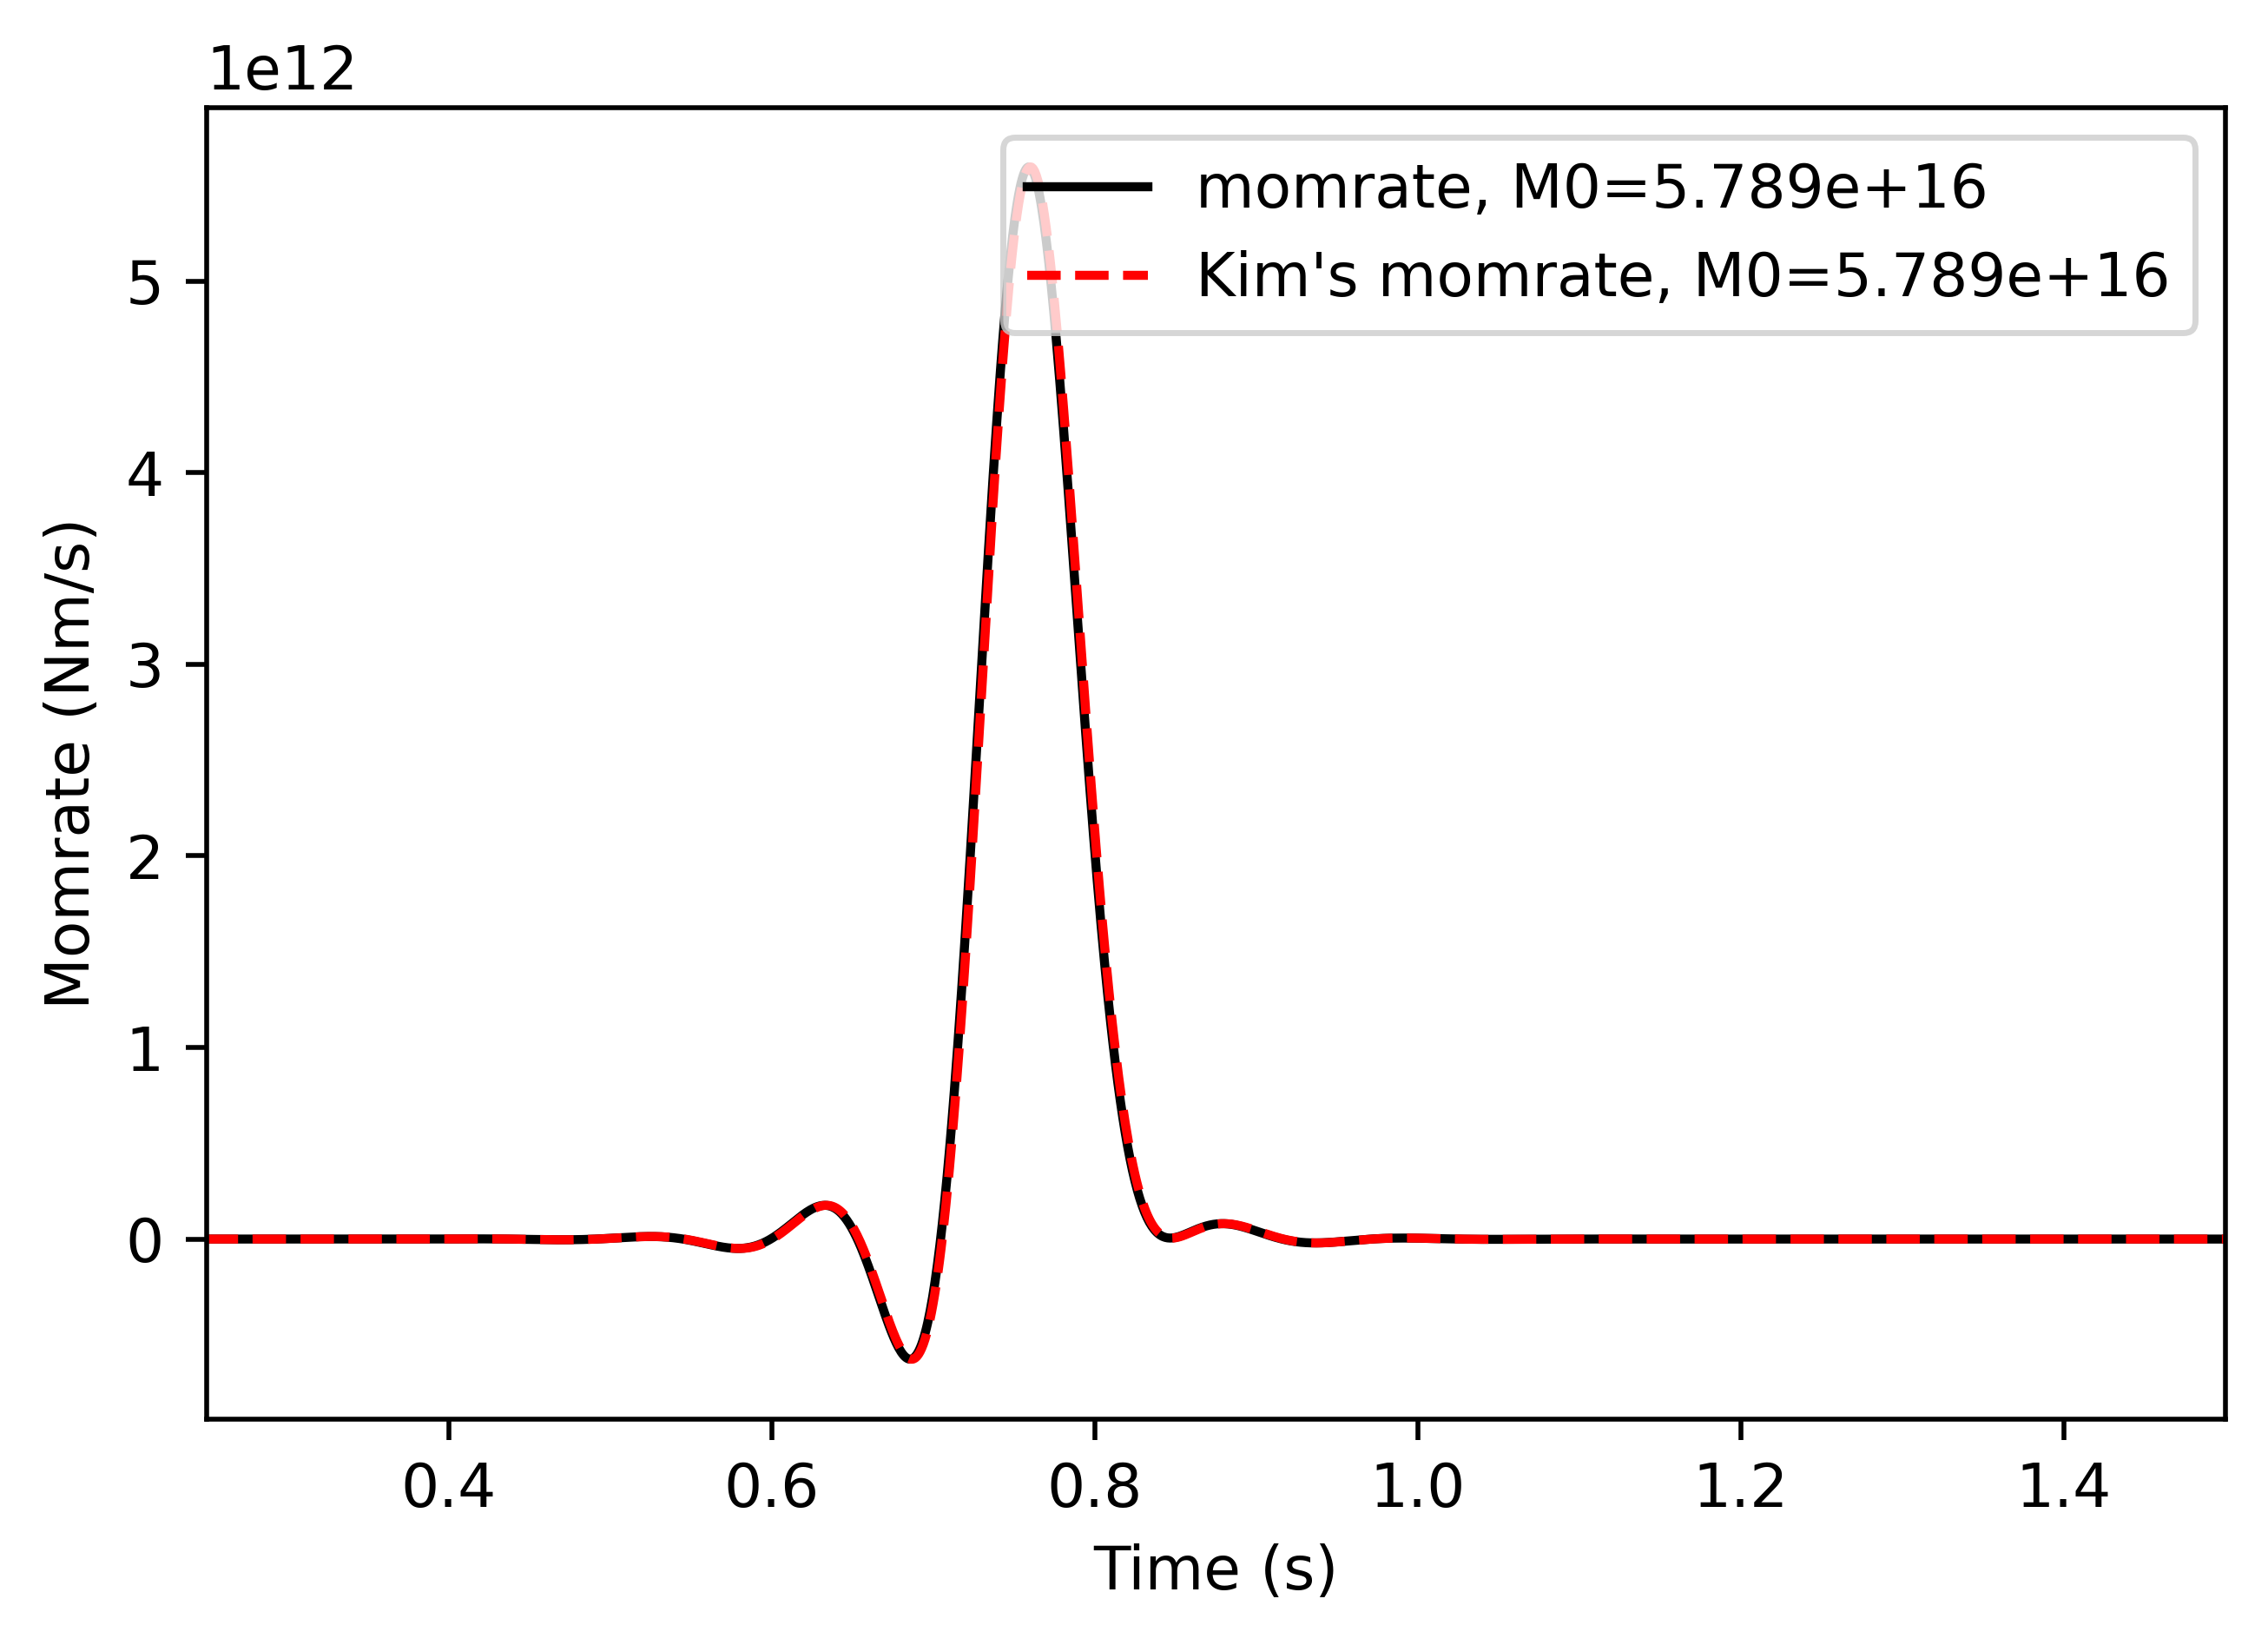

In [6]:
fig, ax = plt.subplots(dpi=500)
ax.plot(np.arange(nt2) * dt2, filt_B(mom2, 1/dt2, 0, 10), 'k', label=f'momrate, M0={np.sum(moment2):.3e}')
ax.plot(np.arange(nt1) * dt1, mom1, 'r--', label=f"Kim's momrate, M0={np.sum(moment2):.3e}")

#ax.plot(np.arange(nt1) * dt1, filt_B(srate, 1/dt1, 0, 10), '-.', label='sliprate')
ax.legend(loc=1)
ax.set(xlabel='Time (s)', ylabel='Momrate (Nm/s)', xlim=(0.5,1))
ax.set_xlim(0.25, 1.5)

In [11]:
dz = 0.008
for i in np.arange(4.3, 4.5, dz):
    depth_8 = np.int(float(i) / dz + 0.5)
    depth_100 = int(np.int(float(i) / 0.1 + 0.5) * 0.1 // dz)
    print(f'Depth={i:.3f} km:      idx_8m={depth_8}, depth_8m={depth_8*dz:.3f}, '
          f'idx_100m={depth_100}, depth_100m={depth_100*dz-0.1:.3f}')

Depth=4.300 km:      idx_8m=538, depth_8m=4.304, idx_100m=537, depth_100m=4.196
Depth=4.308 km:      idx_8m=539, depth_8m=4.312, idx_100m=537, depth_100m=4.196
Depth=4.316 km:      idx_8m=540, depth_8m=4.320, idx_100m=537, depth_100m=4.196
Depth=4.324 km:      idx_8m=541, depth_8m=4.328, idx_100m=537, depth_100m=4.196
Depth=4.332 km:      idx_8m=542, depth_8m=4.336, idx_100m=537, depth_100m=4.196
Depth=4.340 km:      idx_8m=543, depth_8m=4.344, idx_100m=537, depth_100m=4.196
Depth=4.348 km:      idx_8m=544, depth_8m=4.352, idx_100m=537, depth_100m=4.196
Depth=4.356 km:      idx_8m=545, depth_8m=4.360, idx_100m=550, depth_100m=4.300
Depth=4.364 km:      idx_8m=546, depth_8m=4.368, idx_100m=550, depth_100m=4.300
Depth=4.372 km:      idx_8m=547, depth_8m=4.376, idx_100m=550, depth_100m=4.300
Depth=4.380 km:      idx_8m=548, depth_8m=4.384, idx_100m=550, depth_100m=4.300
Depth=4.388 km:      idx_8m=549, depth_8m=4.392, idx_100m=550, depth_100m=4.300
Depth=4.396 km:      idx_8m=550, depth_8

[Text(0, 0.5, '$\\mu$'), Text(0.5, 0, 'Subfault')]

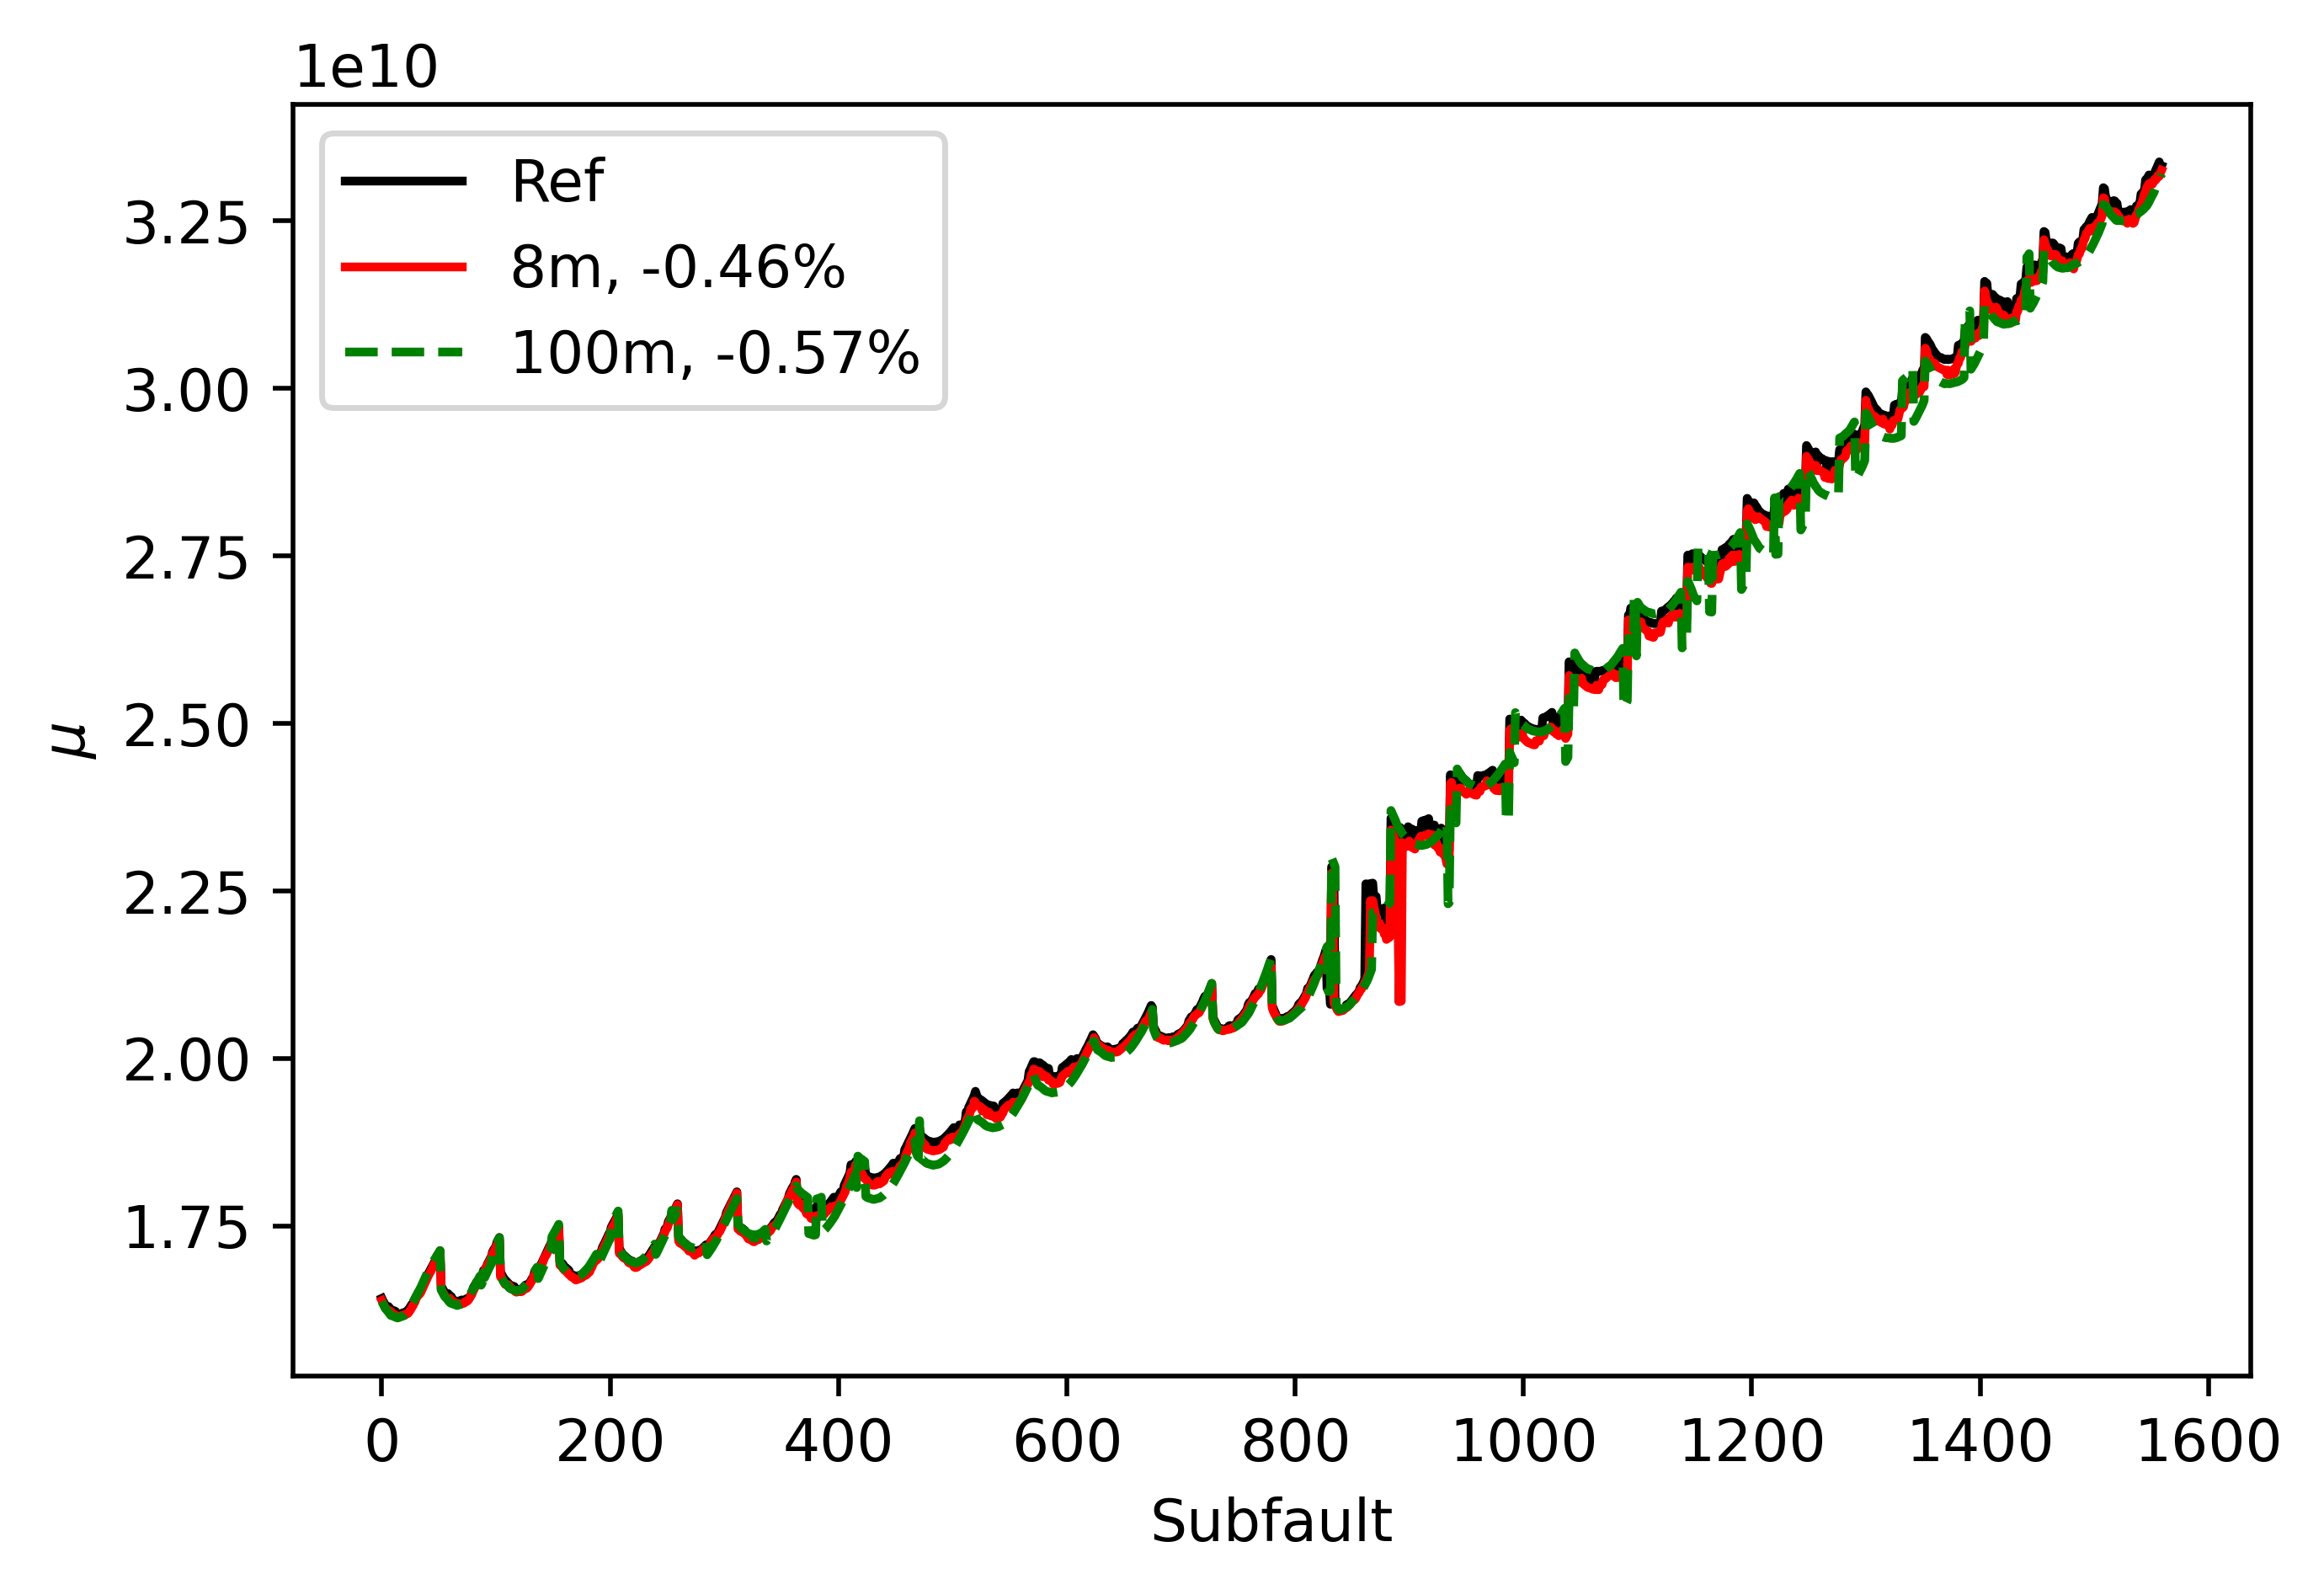

In [14]:
sub_ref = np.genfromtxt('100m_lat_lon_mu.txt')[:,3]
sub_8m = np.genfromtxt('subfaults_8m.idx')[:, 4]
sub_100m = np.genfromtxt('subfaults_100m.idx')[:, 4]
diff_8m = np.divide(sub_8m - sub_ref, sub_ref) * 100
diff_100m = np.divide(sub_100m - sub_ref, sub_ref) * 100                
fig, ax = plt.subplots(dpi=500)
ax.plot(sub_ref, 'k', label='Ref')
ax.plot(sub_8m, 'r', label=f'8m, {np.mean(diff_8m):.2f}%')
ax.plot(sub_100m, 'g--', label=f'100m, {np.mean(diff_100m):.2f}%')
ax.legend(loc=2)
ax.set(xlabel='Subfault', ylabel='$\mu$')

[Text(0, 0.5, 'Difference%'), Text(0.5, 0, 'Subfault')]

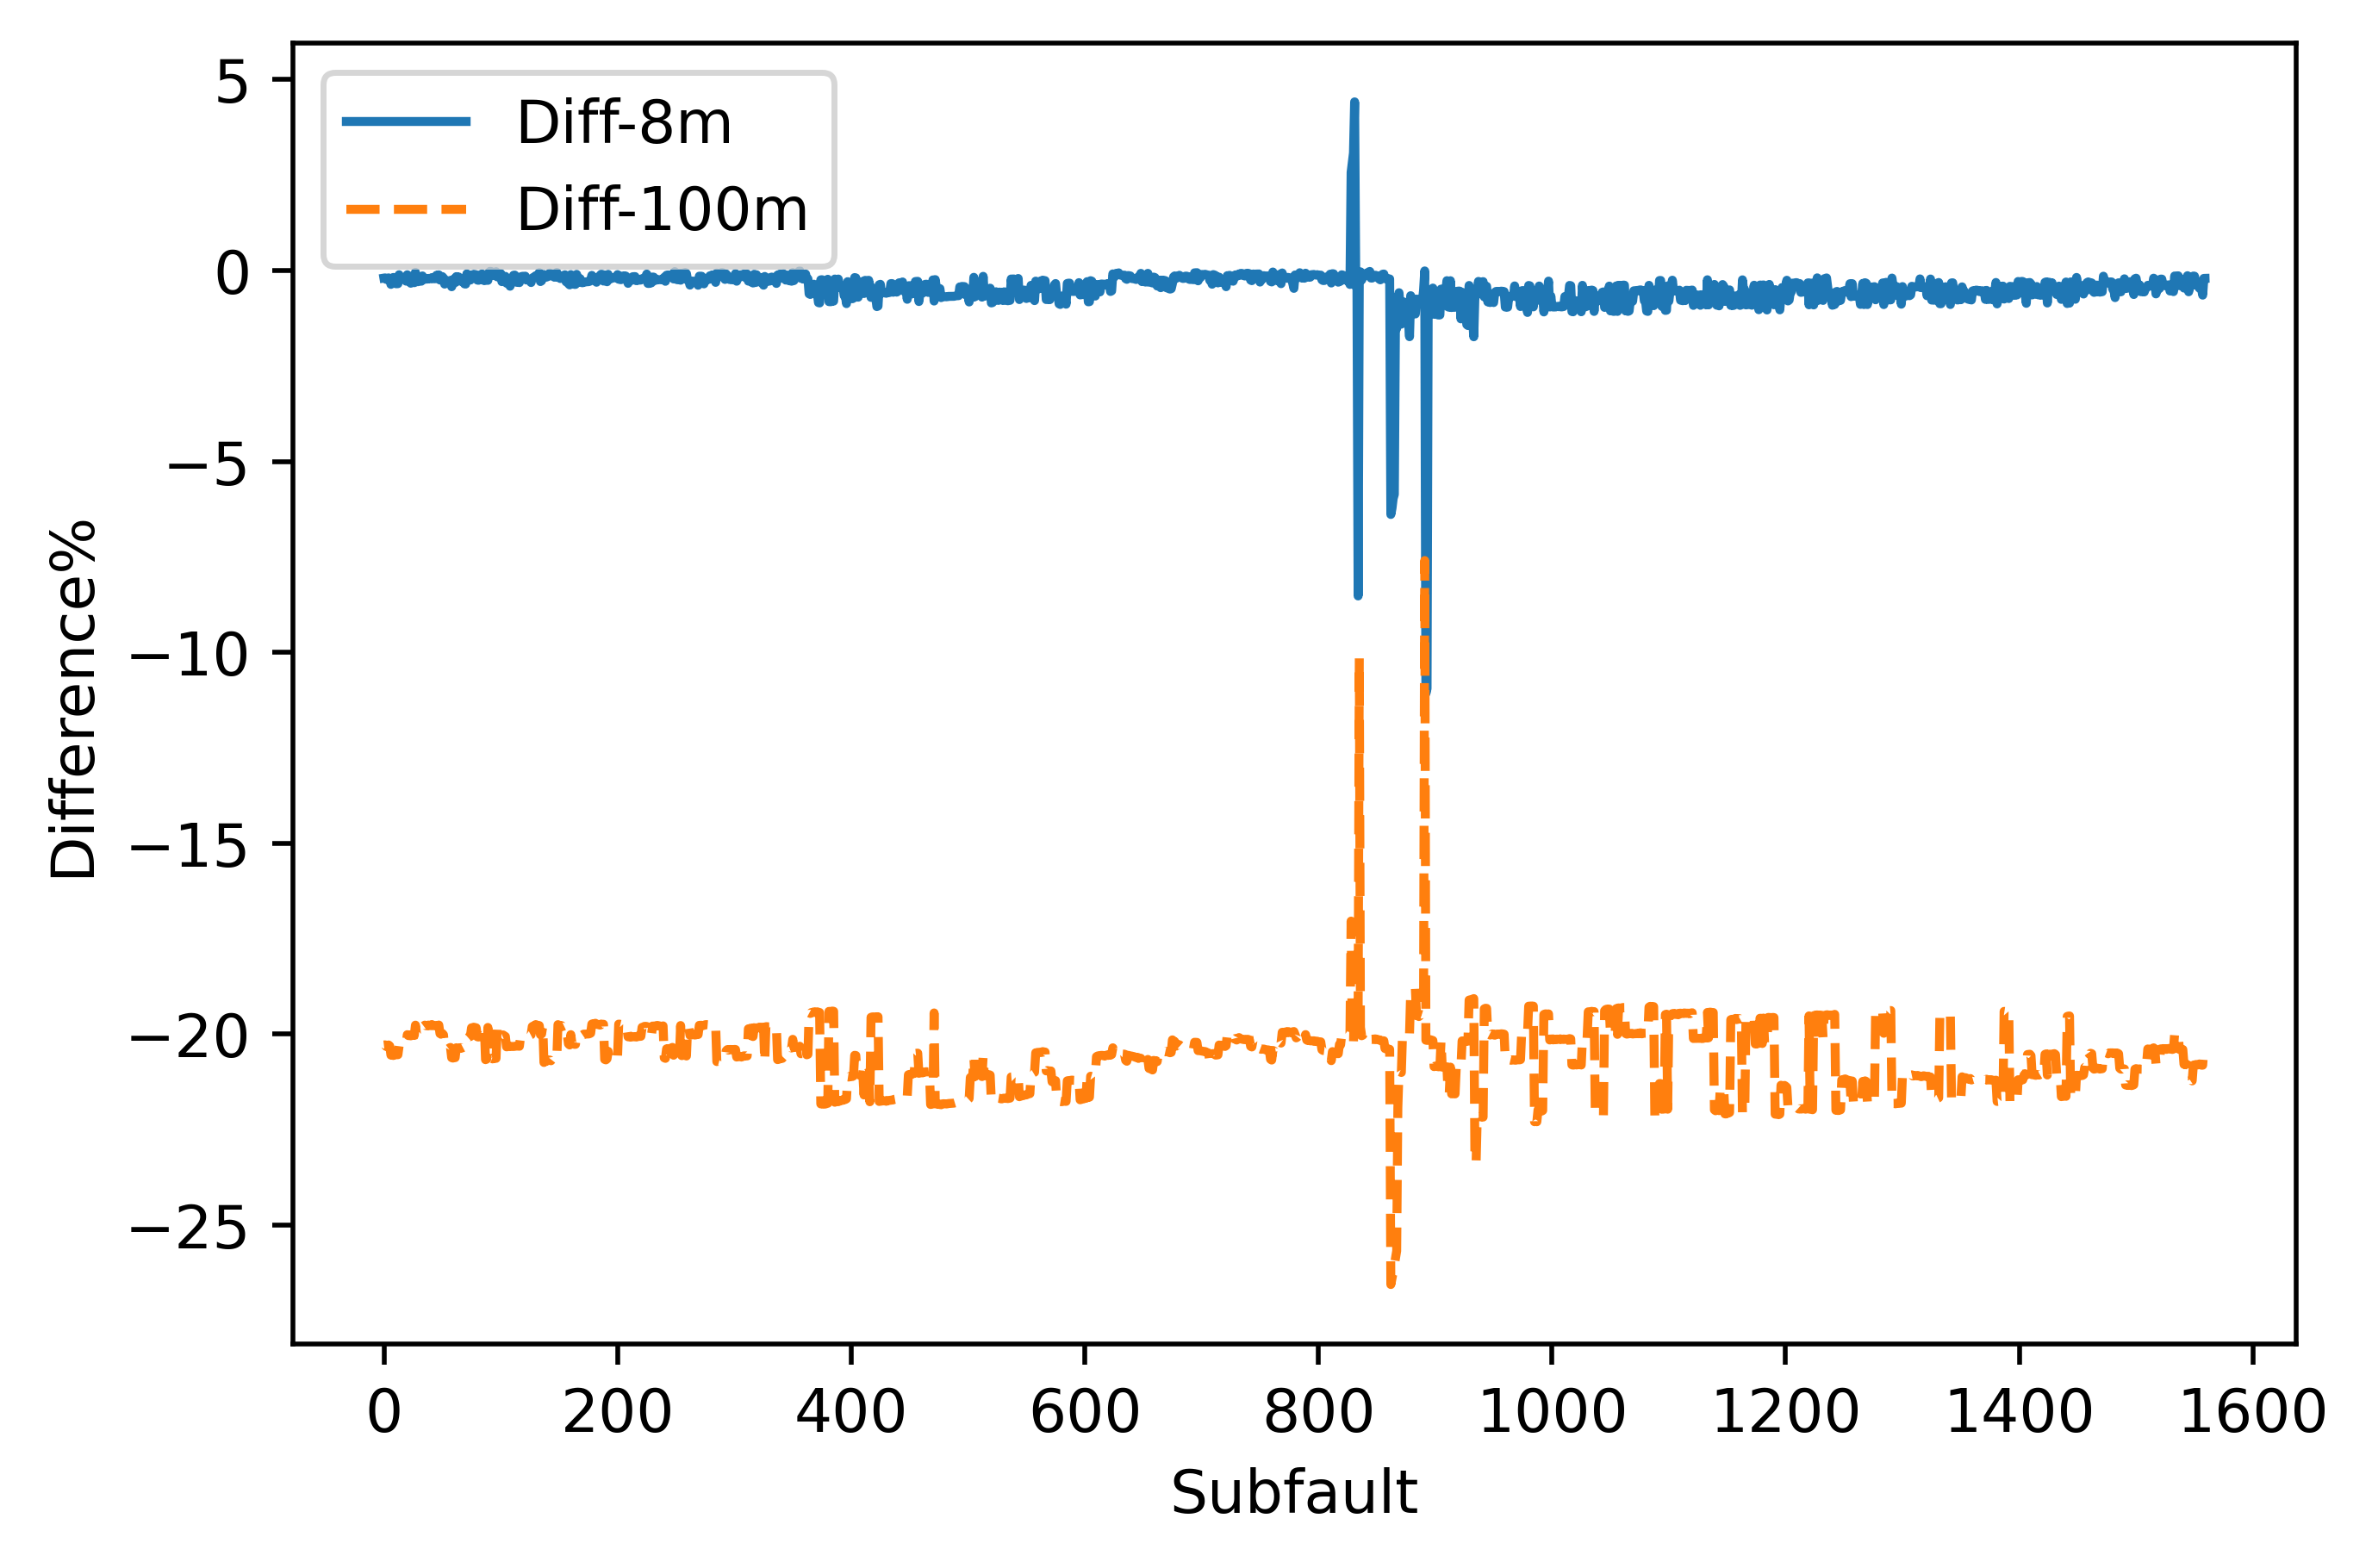

In [13]:
fig, ax = plt.subplots(dpi=500)
ax.plot(diff_8m, label='Diff-8m')
ax.plot(diff_100m-20, '--', label=f'Diff-100m')
ax.legend(loc=2)
ax.set(xlabel='Subfault', ylabel='Difference%')

In [ ]:
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
import struct
from mpl_toolkits.mplot3d import Axes3D
from scipy.fftpack import fft2, ifft2, fftshift, ifftshift

# tight_layout() only considers ticklabels, axis labels, and titles. Thus, other artists may be clipped and also may overlap.
# [left, bottom, right, top] in normalized (0, 1) figure coordinates
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
rcparams = {'font.size': 16,
            'xtick.labelsize': 10,
            'ytick.labelsize': 10,
            'legend.fontsize': 14,
            'axes.titlesize': 16,
            'axes.labelsize': 14,
            'lines.linewidth': 1.5,
            'figure.dpi': 300}
plt.rcParams.update(rcparams)
plt.style.use('default')

nx, ny = 3500, 3500
mx, my = nx // 54 * 54, ny // 54 * 54
mx, my = 200, 200
px, py = (nx - mx) // 2, (ny - my) // 2
MX, MY = mx + 2 * pad, my + 2 * pad
pad = 8
dh = 8
grid = np.fromfile('surf.grid', dtype='float64').reshape(ny, nx, 3)
lon = grid[:, :, 0]
lat = grid[:, :, 1]
del grid

print(f"Left lower corner: {lon[0, 0]}, {lat[0, 0]}\n"
      f"Right lower corner: {lon[0, -1]}, {lat[0, -1]}\n"
      f"Left upper corner: {lon[-1, 0]}, {lat[-1, 0]}\n"
      f"Right upper corner: {lon[-1, -1]}, {lat[-1, -1]}")

dem_head = np.genfromtxt('dem.txt', dtype='float')
print(dem_head)

NY, NX = int(dem_head[0]), int(dem_head[1])
left, right, bot, top = dem_head[2:]

dem = np.fromfile('dem.bin', dtype='float32').reshape(NY, NX)
dx = (right - left) / NX
dy = (top - bot) / NY




In [ ]:
with open('topography.bin', 'rb') as fout:
    mx, my, pad = np.frombuffer(fout.read(12), dtype='int32')
    topo = np.frombuffer(fout.read((mx + 2 * pad) * (my + 2 * pad) * 4), dtype='float32').reshape(mx + 2 * pad, my + 2 * pad)
    
top = topo[pad : mx + pad, pad : my + pad]